# Microstructure classification using Neural Networks

In this example, we will generate microstructures of 4 different types with different grain sizes. 
Then we will split the dataset into training and testing set.

Finally we will trian the neural network using CrysX-NN to make predictions.

## Run the following cell for Google colab 
then restart runtime

In [ ]:
! pip install --upgrade --no-cache-dir https://github.com/manassharma07/crysx_nn/tarball/main
! pip install pymks
! pip install IPython==7.7.0

## Import necessary libraries
We will use PyMKS for generation artificial microstructures.

In [1]:
from pymks import (
    generate_multiphase,
    plot_microstructures,
#     PrimitiveTransformer,
#     TwoPointCorrelation,
#     FlattenTransformer,
#     GenericTransformer
)
import numpy as np
import matplotlib.pyplot as plt

## Define some parameters
like number of samples per type, the width and height of a microstructure image in pixels.

In [2]:
nSamples_per_type = 10000
width = 100
height = 100

## Generate microstructures
The following code will generate microstructures of 4 different types.

The first type has 6 times more grain boundaries along the x-axis than the y-axis.

The second type has 4 times more grain boundaries along the y-axis than the x-axis.

The third type has same number of grain boundaries along the x-axis as well as the y-axis.

The fourth type has 6 times more grain boundaries along the y-axis than the x-axis.

In [3]:
grain_sizes = [(30, 5), (10, 40), (15, 15), (5, 30)]
seeds = [10, 99, 4, 36]

data_synth = np.concatenate([
    generate_multiphase(shape=(nSamples_per_type, width, height), grain_size=grain_size,
        volume_fraction=(0.5, 0.5),
        percent_variance=0.2,
        seed=seed
    )
    for grain_size, seed in zip(grain_sizes, seeds)
])



C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\toolz\functoolz.py:306: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self._partial(*args, **kwargs)
C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\toolz\functoolz.py:306: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self._partial(*args, **kwargs)
C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\toolz\functoolz.py:306: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self._partial(*args, **kwa

## Plot a microstructure of each type 

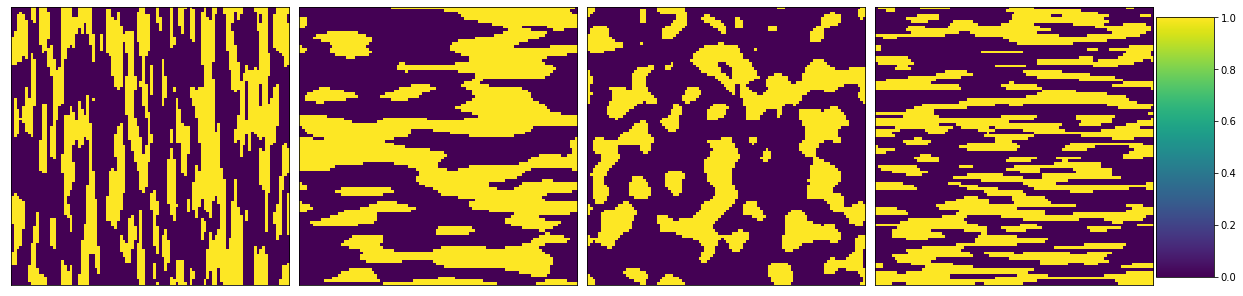

In [4]:
plot_microstructures(*data_synth[::nSamples_per_type+0], colorbar=True)
# plot_microstructures(*data_synth[::nSamples_per_type+1], colorbar=True)
# plot_microstructures(*data_synth[::nSamples_per_type+2], colorbar=True)
# plot_microstructures(*data_synth[::nSamples_per_type+3], colorbar=True)
#plt.savefig("Microstructures.png",dpi=600,transparent=True)
plt.show()

## Check the shape of the data generated
The first dimension corresponds to the total number of samples, the second and third axes are for width and height.

In [5]:
# Print shape of the array
print(data_synth.shape)
print(type(data_synth))

(40000, 100, 100)
<class 'numpy.ndarray'>


## Rename the generated data --> `X_data` as it is the input data

In [6]:
X_data = np.array(data_synth)
print(X_data.shape)

(40000, 100, 100)


## Create the target/true labels for the data
The microstructure data we have generated is such that the samples of different types are grouped together. Furthermore, their order is the same as the one we provided when generating the data. 

Therefore, we can generate the true labels quite easily by making a numpy array whose first `nSamples_per_type` elements correspond to type 0, and so on upto type 3.

In [7]:
Y_data = np.concatenate([np.ones(nSamples_per_type)*0,np.ones(nSamples_per_type)*1,np.ones(nSamples_per_type)*2,np.ones(nSamples_per_type)*3])

In [8]:
print(Y_data)
print(Y_data.shape)

[0. 0. 0. ... 3. 3. 3.]
(40000,)


## Plot some samples taken from the data randomly as well as their labels that we created for confirmation

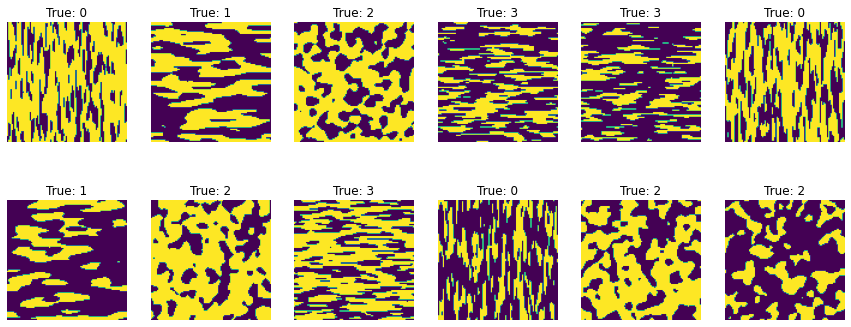

In [9]:
rng = np.random.default_rng()
### Plot examples
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
for axes_row in axes:
    for ax in axes_row:
        test_index = rng.integers(0, len(Y_data))
        image =  X_data[test_index]
        orig_label = Y_data[test_index]
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i' % orig_label)

## Use sklearn to split the data into train and test set

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Split into train and test
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = train_test_split(X_data, Y_data, test_size=0.20, random_state=1)

## Some statistics of the training data

In [12]:
print('Training data MIN',X_train_orig.min())
print('Training data MAX',X_train_orig.max())
print('Training data MEAN',X_train_orig.mean())
print('Training data STD',X_train_orig.std())

Training data MIN 0
Training data MAX 1
Training data MEAN 0.49983095625
Training data STD 0.49999997142421193


## Check some shapes

In [13]:
print(X_train_orig.shape)
print(Y_train_orig.shape)
print(X_test_orig.shape)
print(Y_test_orig.shape)

(32000, 100, 100)
(32000,)
(8000, 100, 100)
(8000,)


## Flatten the input pixel data for each sample by reshaping the 2d array of size `100,100`, for each sample to a 1d array of size `100*100`

In [14]:
X_train = X_train_orig.reshape(X_train_orig.shape[0], width*height)
X_test = X_test_orig.reshape(X_test_orig.shape[0], width*height)

## Check the shapes

In [15]:
print(X_train.shape)
print(X_test.shape)

(32000, 10000)
(8000, 10000)


## Use a utility from CrysX-NN to one-hot encode the target/true labels  

This means that a sample with type 3 will be represented as an array [0,0,0,1]

In [16]:
from crysx_nn import mnist_utils as mu
Y_train = mu.one_hot_encode(Y_train_orig, 4)
Y_test = mu.one_hot_encode(Y_test_orig, 4)

In [17]:
print(Y_train.shape)
print(Y_test.shape)

(32000, 4)
(8000, 4)


## Standardize the training and testing input data using the mean and standard deviation of the training data

In [18]:
X_train = (X_train - np.mean(X_train_orig)) / np.std(X_train_orig)
X_test = (X_test - np.mean(X_train_orig)) / np.std(X_train_orig)

# Some statistics after standardization
print('Training data MIN',X_train.min())
print('Training data MAX',X_train.max())
print('Training data MEAN',X_train.mean())
print('Training data STD',X_train.std())
print('Testing data MIN',X_test.min())
print('Testing data MAX',X_test.max())
print('Testing data MEAN',X_test.mean())
print('Testing data STD',X_test.std())

Training data MIN -0.9996619696322572
Training data MAX 1.0003381446709014
Training data MEAN -1.0667022820598504e-16
Training data STD 0.9999999999999942
Testing data MIN -0.9996619696322572
Testing data MAX 1.0003381446709014
Testing data MEAN 0.0016794125959809832
Testing data STD 0.999999157574746


## Finally we will begin creating a neural network

Set some important parameters for the Neural Network.

**Note**: In some cases I got NAN values while training. The issue could be circumvented by choosing a different batch size.

In [19]:
nInputs = width*height # No. of nodes in the input layer
neurons_per_layer = [500, 4] # Neurons per layer (excluding the input layer)
activation_func_names = ['ReLU', 'Softmax']
nLayers = len(neurons_per_layer)
nEpochs = 4
batchSize = 32 # No. of input samples to process at a time for optimization

## Create the neural network model
Use the parameters define above to create the model

In [20]:
from crysx_nn import network
model = network.nn_model(nInputs=nInputs, neurons_per_layer=neurons_per_layer, activation_func_names=activation_func_names, batch_size=batchSize, device='CPU', init_method='Xavier') 

model.lr = 0.02

Note: The model will use the following device for all the computations:  CPU


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\crysx_nn\network.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Check the details of the Neural Network

In [21]:
model.details()

----------------------------------------------------------------------------------
****Neural Network Model Details****
----------------------------------------------------------------------------------
Number of input nodes:  10000
Number of layers (hidden+output):  2
Number of nodes in each layer (hidden & output):  [500, 4]
Activation function for each layer (hidden & output):   ['ReLU', 'Softmax']
Method used for weights and biases initialization:   Xavier
Batch Size:  32
Device:  CPU
Optimization method:  SGD
Learning rate:  0.02
----------------------------------------------------------------------------------


## Visualize the neural network

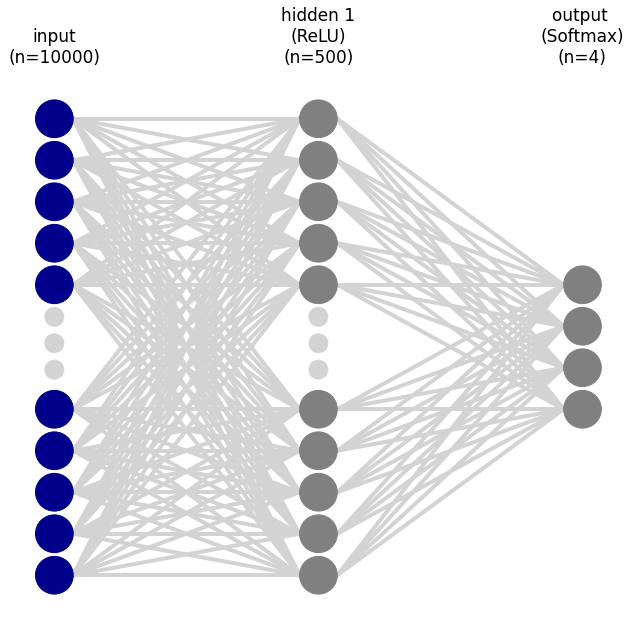

In [22]:
model.visualize()

## Begin optimization/training

We will use `float32` precision, so convert the input and output arrays.

We will use Binary Cross Entropy for the loss function.

In [23]:
inputs = X_train.astype(np.float32)
outputs = Y_train.astype(np.float32)
# Run optimization
# model.optimize(inputs, outputs, lr=0.02,nEpochs=nEpochs,loss_func_name='BCE', miniterEpoch=1, batchProgressBar=True, miniterBatch=100)
# To get accuracies at each epoch
model.optimize(inputs, outputs, lr=0.02,nEpochs=nEpochs,loss_func_name='BCE', miniterEpoch=1, batchProgressBar=True, miniterBatch=100, get_accuracy=True)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.46943440030198635


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## Error at each epoch

In [24]:
print(model.errors)

[0.46943440030198635, 0.18253978361109716, 0.045632812921753564, 0.01599540651570341]


## Accuracy at each epoch

In [25]:
print(model.accuracy)

[0.54309375, 0.93571875, 0.99725, 1.0]


## Save model weights and biases

In [26]:
# Save weights
model.save_model_weights('NN_crysx_microstructure_96_weights')
# Save biases
model.save_model_biases('NN_crysx_microstructure_96_biases')

## Load model weights and biases from files

In [27]:
model.load_model_weights('NN_crysx_microstructure_96_weights')
model.load_model_biases('NN_crysx_microstructure_96_biases')

## Performance on Test data

In [28]:
## Convert to float32 arrays
inputs = X_test.astype(np.float32)
outputs = Y_test.astype(np.float32)
# predictions, error = model.predict(inputs, outputs, loss_func_name='BCE')
# print('Error:',error)
# print(predictions)
predictions, error, accuracy = model.predict(inputs, outputs, loss_func_name='BCE', get_accuracy=True)
print('Error:',error)
print('Accuracy %:',accuracy*100)

Error: 0.07394811087767096
Accuracy %: 97.02499999999999


## Confusion matrix

Confusion matrix:
 [[2012.    0.   14.    0.]
 [   0. 1942.    0.   65.]
 [   3.    3. 1945.    5.]
 [   0.  143.    5. 1863.]]


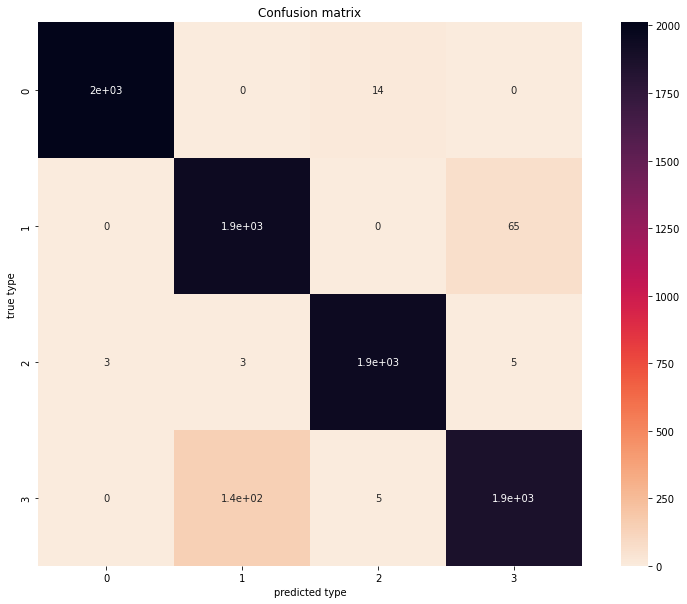

In [29]:
from crysx_nn import utils

# Get the indices of the maximum probabilities for each sample in the predictions array
pred_type = np.argmax(predictions, axis=1)
# Get the digit index from the one-hot encoded array
true_type = np.argmax(Y_test, axis=1)
# Calculation confusion matrix
cm = utils.compute_confusion_matrix(pred_type, true_type)
print('Confusion matrix:\n',cm)

# Plot the confusion matrix
utils.plot_confusion_matrix(cm)

## Draw some random images from the test dataset and compare the true labels to the network outputs

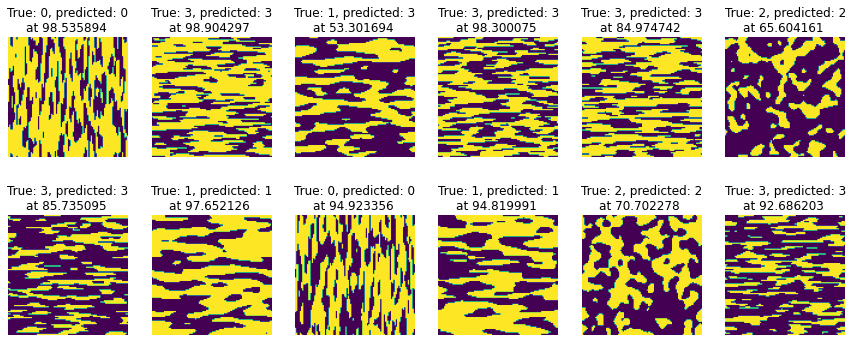

In [30]:
### Draw some random images from the test dataset and compare the true labels to the network outputs
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
### Loop over subplots
for axes_row in axes:
    for ax in axes_row:
        ### Draw the images
        test_index = rng.integers(0, len(Y_test_orig))
        image = X_test[test_index].reshape(width, height) # Use X_test instead of X_test_orig as X_test_orig is not standardized
        orig_label = Y_test_orig[test_index]
        ### Compute the predictions
        input_array = image.reshape([1,width*height])
        output = model.predict(input_array)
        # Get the maximum probability 
        certainty = np.max(output)
        # Get the index of the maximum probability
        output = np.argmax(output)
        
        ### Show image
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i, predicted: %i\nat %f ' % (orig_label, output, certainty*100))